# Import the packages

Before running your first cell, make sure GPU is enabled! Click the three dots in the upper right, go to 'Accelerator' and select 'GPU P100'

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import nn
from torchmetrics.classification import BinaryF1Score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from inception_model import Inception, InceptionBlock

# Load and preprocess the training data

In [2]:
# Loading the data files from Kaggle into this workspace
basal_train = np.load('/kaggle/input/ix-neuroengineering-symposium-epilepsy-challenge/basal_train.npy')
pre_seizure_train = np.load('/kaggle/input/ix-neuroengineering-symposium-epilepsy-challenge/pre_seizure_train.npy')

# Checking the dimensions of our data
print(basal_train.shape)
print(pre_seizure_train.shape)

# Original train data is 3x2x24000, 3 subjects, 2 electrodes and 240 seconds
# Below we will concatenate across subjects

# Reshape basal_train to a 2x72000 matrix (2 electrodes, 720 seconds of data)
basal_train_reshaped = basal_train.reshape((basal_train.shape[1], -1))
pre_seizure_train_reshaped = pre_seizure_train.reshape((pre_seizure_train.shape[1], -1))

# Check the dimensions of basal_train_reshaped
print(basal_train_reshaped.shape)
print(pre_seizure_train_reshaped.shape)

(3, 2, 240000)
(3, 2, 60000)
(2, 720000)
(2, 180000)


In [3]:
# Loading the data files from Kaggle into this workspace
basal_train = np.load('/kaggle/input/ix-neuroengineering-symposium-epilepsy-challenge/basal_train.npy')
pre_seizure_train = np.load('/kaggle/input/ix-neuroengineering-symposium-epilepsy-challenge/pre_seizure_train.npy')
# Checking the dimensions of our data
print(basal_train.shape)
print(pre_seizure_train.shape)

# Original train data is 3x2x24000, 3 subjects, 2 electrodes and 240 seconds
# Below we will concatenate across subjects

# Reshape basal_train to a 2x48000 matrix (2 electrodes, 480 seconds of data)
basal_train_reshaped = basal_train.reshape((basal_train.shape[1], -1))
pre_seizure_train_reshaped = pre_seizure_train.reshape((pre_seizure_train.shape[1], -1))

# Check the dimensions of basal_train_reshaped
print(basal_train_reshaped.shape)
print(pre_seizure_train_reshaped.shape)

(3, 2, 240000)
(3, 2, 60000)
(2, 720000)
(2, 180000)


## Slice data into 2s segments

In [3]:
# Create a function to receive longer segments of data and divide it into smaller blocks

# The function receives the data variable, the size of the smaller blocks it will be divided into
# and the related training labels (which tell whether that block is pre-epileptic or not)
def create_windows_per_recording(data, window_size, label):
    # Initialize the variables
    windows = []
    labels = []
    
    # Compute the number of windows based on the length of the data and the size of the window
    num_windows = (data.shape[1] - window_size) // window_size + 1
    for i in range(num_windows):
        # Fill the windows with segments of the original data
        window = data[:, i * window_size : i * window_size + window_size]
        windows.append(window)
        labels.append(label)
        
    # Return the resulting smaller windows and its labels
    return np.array(windows), np.array(labels)

### Balance the labels 50/50

In [4]:
# Creates a function to subsample an imbalanced dataset and enforce a 50/50 label distribution

# The function receives your X and y train-validation datasets and returns a subsampled version of them
def balance_labels(X_train, X_val, y_train, y_val):
    # Calculate the number of pre-epileptic samples
    num_pre_epileptic_train = np.sum(y_train == 1)
    num_pre_epileptic_val = np.sum(y_val == 1)
    
    # Calculate the number of desired basal samples
    desired_num_basal_train = num_pre_epileptic_train
    desired_num_basal_val= num_pre_epileptic_val

    # Select the basal samples for the train set
    basal_train_indices = np.where(y_train == 0)[0]
    
    # Select the basal samples for the validation set
    basal_val_indices = np.where(y_val == 0)[0]

    # Randomly subsample the basal indices
    selected_basal_train_indices = np.random.choice(basal_train_indices, size=desired_num_basal_train, replace=False)
    selected_basal_val_indices = np.random.choice(basal_val_indices, size=desired_num_basal_val, replace=False)
    
    # Get the pre-epileptic sample indices
    selected_pre_epileptic_train_indices = np.where(y_train == 1)[0]
    selected_pre_epileptic_val_indices = np.where(y_val == 1)[0]

    # Combine the selected pre-epileptic and basal windows for the validation set
    selected_train_indices = np.concatenate([selected_pre_epileptic_train_indices, selected_basal_train_indices])
    
    # Combine the selected pre-epileptic and basal windows for the validation set
    selected_val_indices = np.concatenate([selected_pre_epileptic_val_indices, selected_basal_val_indices])

    # Update the training and validation sets
    X_val = X_val[selected_val_indices]
    y_val = y_val[selected_val_indices]

    # Update the training and validation sets
    X_train = X_train[selected_train_indices]
    y_train = y_train[selected_train_indices]

    return X_train, X_val, y_train, y_val


## Set parameters and split train-test data


In [5]:
# Parameters
window_size = 2000  # equivalent to two seconds of data, equal to the test samples

# Create windows
# Assign '0' to the basal (non pre-epileptic) data and '1' to pre-epileptic
basal_windows, basal_labels = create_windows_per_recording(basal_train_reshaped, window_size, 0) 
pre_seizure_windows, pre_seizure_labels = create_windows_per_recording(pre_seizure_train_reshaped, window_size, 1)

'''
# Oversample pre_seizure_windows to have the same number of samples as basal_windows
num_basal_windows = basal_windows.shape[0]
num_pre_seizure_windows = pre_seizure_windows.shape[0]
oversampled_pre_seizure_windows = pre_seizure_windows[np.random.choice(num_pre_seizure_windows, size=num_basal_windows, replace=True)]
oversampled_pre_seizure_labels = np.ones(num_basal_windows)

# Concatenate the training windows and their labels
X_train = np.concatenate([basal_windows, oversampled_pre_seizure_windows])
y_train = np.concatenate([basal_labels, oversampled_pre_seizure_labels])
'''
X_train = np.concatenate([basal_windows, pre_seizure_windows])
y_train = np.concatenate([basal_labels, pre_seizure_labels])
# remove the singleton dimension
X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train)

'''
##### Data augmentations #####

# Artificially create "new" samples by slightly modifying the originals

# Noise
noise = np.random.normal(0, 0.05, X_train.shape)
aug_noise = X_train + noise

# Scaling
scaling_factor = np.random.uniform(0.5, 1.5)
aug_scale = X_train * scaling_factor

# Flipping
aug_flipped = X_train[:, ::-1]

###############################

# Append augmented data to original training dataset
X_train = np.concatenate([X_train, aug_noise, aug_scale, aug_flipped])
y_train = np.concatenate([y_train, y_train, y_train, y_train])
'''
# Split data into training and validation sets 
# 'test_size' specifies % of data towards validation set, 0.2 = 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Balance the training and validation set labels
X_train, X_val, y_train, y_val = balance_labels(X_train, X_val, y_train, y_val)

In [6]:
# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

# Print the number of pre-epileptic and basal windows in the training and validation sets
print("Number of pre-epileptic windows in the training set: ", np.sum(y_train == 1))
print("Number of basal windows in the training set: ", np.sum(y_train == 0))

print("Number of pre-epileptic windows in the validation set: ", np.sum(y_val == 1))
print("Number of basal windows in the validation set: ", np.sum(y_val == 0))

# Print the proportions of pre-epileptic and basal windows in the training and validation sets
print("Proportion of pre-epileptic windows in the training set: ", np.sum(y_train == 1) / len(y_train))
print("Proportion of basal windows in the training set: ", np.sum(y_train == 0) / len(y_train))

print("Proportion of pre-epileptic windows in the validation set: ", np.sum(y_val == 1) / len(y_val))
print("Proportion of basal windows in the validation set: ", np.sum(y_val == 0) / len(y_val))

X_train shape:  (136, 2, 2000)
y_train shape:  (136,)
X_val shape:  (44, 2, 2000)
y_val shape:  (44,)
Number of pre-epileptic windows in the training set:  68
Number of basal windows in the training set:  68
Number of pre-epileptic windows in the validation set:  22
Number of basal windows in the validation set:  22
Proportion of pre-epileptic windows in the training set:  0.5
Proportion of basal windows in the training set:  0.5
Proportion of pre-epileptic windows in the validation set:  0.5
Proportion of basal windows in the validation set:  0.5


## Transform the data into Pytorch datasets and loaders

In [7]:
# Convert data to PyTorch tensors (a data structure)
tensor_x_train = torch.Tensor(X_train) 
tensor_x_val = torch.Tensor(X_val) 
tensor_y_train = torch.Tensor(y_train)
tensor_y_val = torch.Tensor(y_val)

# Create Tensor datasets
train_data = TensorDataset(tensor_x_train, tensor_y_train)
val_data = TensorDataset(tensor_x_val, tensor_y_val)

# Dataloaders (to feed the data into the model during training)
# 'batch_size' defines the chunk size of data to be fed in each training step
batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)


In [8]:
print(tensor_x_val.shape,tensor_y_val.shape)
print(tensor_x_train.shape,tensor_y_train.shape)

torch.Size([44, 2, 2000]) torch.Size([44])
torch.Size([136, 2, 2000]) torch.Size([136])


### Check if the dataloader is functioning properly

In [9]:
train_iter = iter(train_loader)
try:
    data, label = next(train_iter)
except StopIteration:
    print("The train_loader is empty.")
    
val_iter = iter(val_loader)
try:
    data, label = next(val_iter)
except StopIteration:
    print("The val_loader is empty.")

# Build the model

## InceptionTime model

In [10]:
class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
	def __init__(self, out_shape):
		super(Reshape, self).__init__()
		self.out_shape = out_shape

	def forward(self, x):
		return x.view(-1, *self.out_shape)

InceptionTime = nn.Sequential(
                    Reshape(out_shape=(2,2000)),
                    InceptionBlock(
                        in_channels=2, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.Dropout(0.3),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.Dropout(0.3),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=1),
        )

## Train the model

In [ ]:
# InceptionTime model

# Loss and optimization
# 'device' sets which computing unit will be used, GPU(cuda) is preferred
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 'criterion' specifies the method to compute loss (an 'error' metric for model prediction)
#criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.BCEWithLogitsLoss().to(device) #BCEWithLogitsLoss is the same as BCE, but with a sigmoid layer added before the BCE

# 'optimizer' sets the algorithm that is used to adjust the weights of the model
# Here we use ADAM, which is a fairly popular optimization algo
# 'lr' means Learning Rate, which modulates how fast the weights are adjusted
optimizer = torch.optim.Adam(InceptionTime.parameters(), lr=0.000001, weight_decay=0.01) #weight_decay is a regularization parameter

# .to(device) simply means whe are directing this to the GPU or CPU (chosen above)
InceptionTime = InceptionTime.to(device)
#InceptionTime.load_state_dict(torch.load('InceptionTime_model_epoch_5000.pth'))

# Initialize training losses, validation losses and F1 scores
f1 = BinaryF1Score().to(device)
train_losses = []
val_losses = []
f1_scores_train = []
f1_scores_val = []

####### Training loop #######

# min_val_loss will be used to save the model with best performance (lowest loss)
min_val_loss = np.inf
# patience defines how many epochs without improvement will be tolerated before early stopping
patience = np.inf
patience_counter = 0

# Training loop
# epoch is each training step
for epoch in range(15000):
    # initialize single evaluation metrics (for this iteration)
    running_loss = 0.0
    running_f1_train = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = InceptionTime(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_f1_train += f1(outputs, labels)

    # Validation loss computation
    val_running_loss = 0.0
    val_running_f1_val = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        outputs = InceptionTime(inputs).squeeze()
        val_loss = criterion(outputs, labels)

        val_running_loss += val_loss.item()
        val_running_f1_val += f1(outputs, labels)

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))
    f1_scores_train.append(running_f1_train / len(train_loader))
    f1_scores_val.append(val_running_f1_val / len(val_loader))
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(InceptionTime.state_dict(), 'best_model.pth')
        min_val_loss = val_loss
        patience_counter = 0  # Reset the patience counter
    else:
        # Increment the patience counter
        patience_counter += 1
# Check if we've run out of patience
    if patience_counter >= patience:
        print("Early stopping...")
        break

    # Save the model every 50 epochs
    if epoch % 50 == 0:
        torch.save(InceptionTime.state_dict(), f'InceptionTime_model_epoch_{epoch}.pth')

    

    print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_running_loss / len(val_loader)}, Training F1 Score: {running_f1_train / len(train_loader)}, Validation F1 Score: {val_running_f1_val / len(val_loader)}')

print('Finished Training')


In [58]:
# Save the InceptionTime model
#torch.save(InceptionTime.state_dict(), 'InceptionTime_model_epoch_5000.pth')

# Load the model from a file
InceptionTime.load_state_dict(torch.load('InceptionTime_model_epoch_2000.pth'))

# CPU-only machine with GPU-trained model
#InceptionTime.load_state_dict(torch.load('InceptionTime_model_epoch_300.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

# Plotting model performance

In [14]:
!pip install zip_files


In [16]:
!zip-folder --auto-root --outfile /kaggle/working/models.zip /kaggle/working

In [12]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

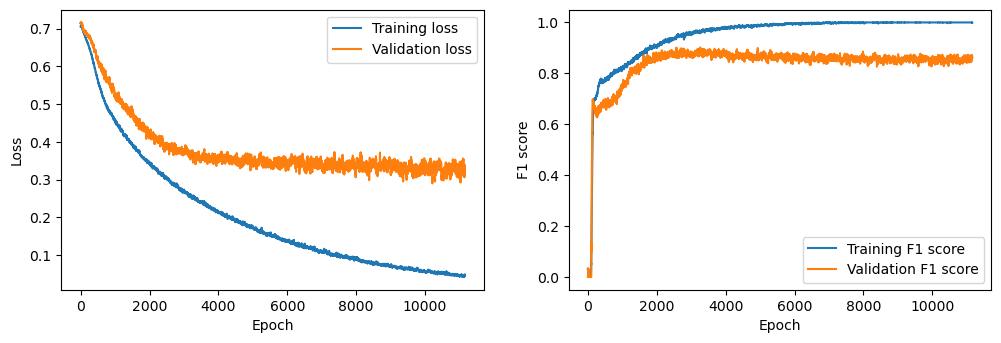

In [49]:
f1_scores_train_np = [score.cpu().numpy() for score in f1_scores_train]  # Convert f1_scores_train to numpy array
f1_scores_val_np = [score.cpu().numpy() for score in f1_scores_val]  # Convert f1_scores_val to numpy array

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(smooth(train_losses,0.9), label='Training loss')
plt.plot(smooth(val_losses,0.9), label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(smooth(f1_scores_train_np,0.9), label='Training F1 score')
plt.plot(smooth(f1_scores_val_np,0.9), label='Validation F1 score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1 score')

plt.show()

np.savez('perf_logs',train_losses,val_losses,f1_scores_train_np,f1_scores_val_np)

# Create submission file using model predictions

In [59]:
# Test the model on the validation dataset
InceptionTime.eval()

with torch.no_grad():
    y_pred_val = InceptionTime(tensor_x_val.to(device))


In [81]:
threshold = 0.38
predictions = torch.sigmoid(y_pred_val) > threshold
predictions = predictions.cpu().numpy().astype(int).squeeze()

print(len(predictions[predictions>0]))
print(f1_score(y_val, predictions))
print(accuracy_score(y_val, predictions))
print(confusion_matrix(y_val,predictions))

30
0.8076923076923077
0.7727272727272727
[[13  9]
 [ 1 21]]


### Test the accuracy of model predictions in the validation dataset

In [ ]:
# Load the test set
X_test = np.load('/kaggle/input/ix-neuroengineering-symposium-epilepsy-challenge/test_set.npy')

# Convert to tensor
tensor_x_test = torch.Tensor(X_test)

# Get model predictions
InceptionTime.eval()
with torch.no_grad():
    y_pred = InceptionTime(tensor_x_test.to(device))

In [75]:
threshold = 0.38
predictions = torch.sigmoid(y_pred) > threshold
predictions = predictions.cpu().numpy().astype(int).squeeze()

# Create submission file
with open("submission.csv", "w") as f:
    f.write("win_id,label\n")
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
        
        
print(len(predictions[predictions>0]))

56
